# LSTM

**Motivation**

https://www.sciencedirect.com/science/article/pii/S2352864821000602

"The prediction of sports performance should adopt nonlinear prediction because there are many factors affecting sports competitions. Taking football games as an example, the stadium will affect the mentality of the players, and a home match is more conducive to the players' performance. The players’ physical and psychological quality, the game tactics, weather factors and even some unexpected accidental factors will also affect the result of the game. Therefore, the linear prediction method cannot consider these factors, but the nonlinear method can."

`Sliding Window`: We plain to build an LSTM model that takes a fixed-size window **(5 games in our case)** of the most recent games as input. This window "slides" across your chronological data, moving forward one game at a time, providing a continuous sequence of input data for the model.

`Cell State Mechanics`: As the window slides, the LSTM updates its internal state based on the information from the current window and what it has retained from the previous window. 
- Forget Gate: Decides which details are no longer needed from the past and removes them from the cell state.
- Input Gate: Adds new information that is relevant to predicting future scores into the cell state.
- Output Gate: Determines what the current output should be based on the cell state and the input at the current step.
This allows the model to maintain a memory of important events over the sequence of windows, or sequences of 5 games.

`Learning Over Time`: As the LSTM processes each sequence of consecutive games, it can learn the dynamics that affect team scores. It understands the context in a sequence, like winning streaks or scoring patterns, which can be crucial for predicting future scores.

`Regression Output`: Unlike the sklearn models, we decided to try to **predict both teams' scores (regression) rather than the outcome (classification)**. Hence the final layer is not a softmax but a dense layer with a linear activation. This layer outputs the predicted numeric values for the team and opponent scores.

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json
from constants.constants import *

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

2024-04-24 13:58:31.640219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 13:58:31.683478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 13:58:31.683508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 13:58:31.684353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 13:58:31.691266: I tensorflow/core/platform/cpu_feature_guar

In [2]:
with open(BORUTA_FEATURES_PATH, 'r') as f:
    selected_features = json.load(f)

In [3]:
label_cols = ['score', 'opponent_score']

additional_cols = ['team', 'opponent', 'country', 'season_start_year']

selected_features = [f for f in selected_features if f not in additional_cols + label_cols]

required_cols = selected_features + additional_cols + label_cols

In [4]:
N_FEATURES = len(selected_features)
print(N_FEATURES)

20


In [5]:
print('season_start_year' in required_cols)

True


In [6]:
SEQUENCE_LENGTH = 5

dfs = []

for year in range(2019, 2023):
    df = pd.read_csv(f'./data/machine_learning/scoreline/{str(year)}.csv')
    df = df[required_cols]
    dfs.append(df)

main_df = pd.concat(dfs, ignore_index=True)

In [7]:
scaler = StandardScaler()
scaler_y = StandardScaler()

features_to_scale = [f for f in selected_features if f != 'is_home']

scaled_data = scaler.fit_transform(main_df[features_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale)
scaled_y = scaler_y.fit_transform(main_df[label_cols])
scaled_y_df = pd.DataFrame(scaled_y, columns=label_cols)
unscaled_df = main_df.drop(columns=features_to_scale + label_cols)
final_df = pd.concat([scaled_df, scaled_y_df, unscaled_df], axis=1)

In [8]:
def create_sequences(df):
    sequences = []
    for _, group in df.groupby(['season_start_year', 'team']):
        for i in range(len(group)):
            start_index = max(0, i - SEQUENCE_LENGTH + 1)
            seq = group.iloc[start_index:i+1].copy()
            if len(seq) < SEQUENCE_LENGTH:
                padding_length = SEQUENCE_LENGTH - len(seq)
                padding_data = pd.DataFrame([[0] * len(seq.columns) for _ in range(padding_length)], columns=seq.columns)
                seq = pd.concat([padding_data, seq], ignore_index=True)
            sequences.append(seq)
    return sequences

def process_data(sequences, train=True):
    X = []
    y = []
    teams = []
    for sequence in sequences:
        team_info = sequence[['team', 'opponent', 'country', 'season_start_year', 'is_home']].iloc[-1]
        features = sequence[selected_features].values
        if train:
            labels = sequence[label_cols].values[-1]
            y.append(labels)
        X.append(features)
        teams.append(team_info.to_dict())
    if train:
        return np.array(X, dtype='float32'), np.array(y), np.array(teams)
    else:
        return np.array(X, dtype='float32'), np.array(teams)

In [9]:
train_df = final_df[final_df['season_start_year'] < 2022]
test_df = final_df[final_df['season_start_year'] >= 2022]

train_sequences = create_sequences(train_df)
test_sequences = create_sequences(test_df)

X_train, y_train, teams_train = process_data(train_sequences)
X_test, y_test, teams_test = process_data(test_sequences)

In [10]:
model = Sequential()
model.add(LSTM(50, activation='tanh',
               input_shape=(SEQUENCE_LENGTH, N_FEATURES),
               kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
               recurrent_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(2, activation='linear', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.compile(optimizer='adam', loss='mse')

2024-04-24 13:58:48.445326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:58:48.530579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:58:48.530648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:58:48.542924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:58:48.543045: I external/local_xla/xla/stream_executor

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 14302 (55.87 KB)
Trainable params: 14302 (55.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


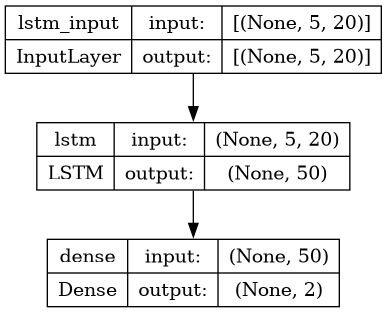

In [12]:
# This saves a PNG image of your model architecture to a file
plot_model(model, to_file='data/machine_learning/img/lstm_model.png', show_shapes=True, show_layer_names=True)

In [13]:
# Create a logs directory with a timestamp to organize training runs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100


2024-04-24 13:58:55.480505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-04-24 13:58:56.528465: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4d2819e1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 13:58:56.528509: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-24 13:58:56.533702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713938336.648628  358937 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 [==============================] - 9s 11ms/step - loss: 3.1231 - val_loss: 1.1903
Epoch 2/100
269/269 [==============================] - 3s 10ms/step - loss: 1.0540 - val_loss: 1.0843
Epoch 3/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9988 - val_loss: 1.0543
Epoch 4/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9849 - val_loss: 1.0442
Epoch 5/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9765 - val_loss: 1.0332
Epoch 6/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9705 - val_loss: 1.0282
Epoch 7/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9676 - val_loss: 1.0235
Epoch 8/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9643 - val_loss: 1.0203
Epoch 9/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9609 - val_loss: 1.0166
Epoch 10/100
269/269 [==============================] - 2s 8ms/step - loss: 0.9573 - val_loss: 1.0128

In [16]:
model.save('data/machine_learning/lstm_model.keras')

In [17]:
model = load_model('data/machine_learning/lstm_model.keras')

In [18]:
# !tensorboard --logdir logs/fit --bind_all

In [19]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
predictions = np.rint(y_pred).astype(int)

115/115 [==============================] - 1s 4ms/step


In [20]:
actual_y_test = scaler_y.inverse_transform(y_test)

In [21]:
np.all(actual_y_test[:, 1] == 1)

False

In [22]:
def return_results(predictions, teams_df, train=True):
    results = []
    for i, prediction in enumerate(predictions):
        team_entry = teams_df[i]  # Assuming teams[i] is a Series with 'team', 'opponent', and 'country'
        predicted_score = prediction[0]
        predicted_opponent_score = prediction[1]
        predicted_outcome = 'W' if predicted_score > predicted_opponent_score else 'L' if predicted_score < predicted_opponent_score else 'D'
        
        # Now add the correct dictionary to your results list
        result = {
            'team': team_entry['team'],
            'opponent': team_entry['opponent'],
            'is_home': team_entry['is_home'],
            'country': team_entry['country'],
            'season_start_year': team_entry['season_start_year'],
            'predicted_score': predicted_score,
            'predicted_opponent_score': predicted_opponent_score,
            'predicted_outcome': predicted_outcome,
        }
        if train:
            actual_score = actual_y_test[i, 0]
            actual_opponent_score = actual_y_test[i, 1]
            actual_outcome = 'W' if actual_score > actual_opponent_score else 'L' if actual_score < actual_opponent_score else 'D'
            result['actual_score'] = actual_score
            result['actual_opponent_score'] = actual_opponent_score
            result['actual_outcome'] = actual_outcome
        results.append(result)
    return results



In [23]:
results = return_results(predictions, teams_test)

# Assuming y_pred and y_test are numpy arrays of the scores
comparison_df = pd.DataFrame(results)

# Sample for inspection
display(comparison_df.sample(10))

,team,opponent,is_home,country,season_start_year,predicted_score,predicted_opponent_score,predicted_outcome,actual_score,actual_opponent_score,actual_outcome
2434,Nice,Reims,1,FRA,2022,2,1,W,2.220446e-16,2.220446e-16,D
1068,Crystal Palace,West Ham,0,ENG,2022,1,2,L,2.000000e+00,1.000000e+00,W
424,Auxerre,Montpellier,1,FRA,2022,1,1,D,2.220446e-16,2.000000e+00,L
800,Brest,PSG,0,FRA,2022,1,2,L,2.220446e-16,1.000000e+00,L
2879,Sassuolo,Verona,1,ITA,2022,2,1,W,2.000000e+00,1.000000e+00,W
3049,Spezia,Torino,0,ITA,2022,1,2,L,1.000000e+00,2.220446e-16,W
1446,Getafe,Atl. Madrid,1,SPA,2022,1,2,L,2.220446e-16,3.000000e+00,L
60,AC Milan,Empoli,0,ITA,2022,2,1,W,3.000000e+00,1.000000e+00,W
3194,Tottenham,Manchester Utd,0,ENG,2022,2,2,D,2.220446e-16,2.000000e+00,L
758,Brentford,Manchester City,1,ENG,2022,1,2,L,1.000000e+00,2.220446e-16,W


Confusion matrix for Test Data

Accuracy: 0.48083242059145676
Precision: 0.49434165420562226
Recall: 0.48083242059145676
F1 Score: 0.48629994115132397
Classification Report:


,precision,recall,f1-score,support
D,0.289474,0.347630,0.315897,886.000000
L,0.570968,0.511931,0.539840,1383.000000
W,0.548961,0.535069,0.541926,1383.000000
accuracy,0.480832,0.480832,0.480832,0.480832
macro avg,0.469801,0.464876,0.465888,3652.000000
weighted avg,0.494342,0.480832,0.486300,3652.000000


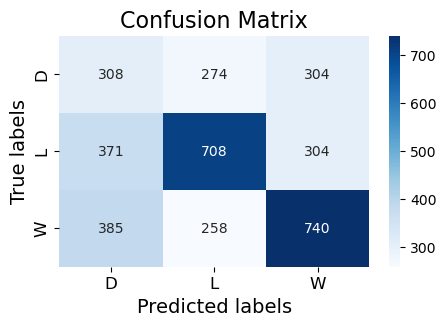

In [30]:
def print_model_results(actual, predicted):
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted, average='weighted', zero_division=0)
    recall = recall_score(actual, predicted, average='weighted', zero_division=0)
    f1 = f1_score(actual, predicted, average='weighted', zero_division=0)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    report = classification_report(actual, predicted, target_names=['D', 'L', 'W'], zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    styled_df = report_df.style.set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    print("Classification Report:")
    display(styled_df)

    conf_matrix = confusion_matrix(actual, predicted, labels=['D', 'L', 'W'])

    fig, ax = plt.subplots(figsize=(5, 3)) 
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['D', 'L', 'W'], yticklabels=['D', 'L', 'W'])

    # Labels, title, and ticks
    label_font = {'size':'14'}
    ax.set_xlabel('Predicted labels', fontdict=label_font)
    ax.set_ylabel('True labels', fontdict=label_font)
    ax.set_title('Confusion Matrix', fontdict={'size':'16'}) 
    ax.tick_params(axis='both', which='major', labelsize=12)

    lstm_metrics_df = pd.DataFrame({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }, index=pd.Index(['LSTM']))
    lstm_metrics_df.to_csv('data/machine_learning/lstm_metrics.csv')

    plt.show()

print_model_results(comparison_df['actual_outcome'], comparison_df['predicted_outcome'])

### Now we try to predict results for 2023-24 (current season)

In [25]:
prediction_df = pd.read_csv('data/machine_learning/2023_predict.csv')
p_scaled_data = scaler.transform(prediction_df[features_to_scale])
p_scaled_df = pd.DataFrame(p_scaled_data, columns=features_to_scale)
p_unscaled_df = prediction_df.drop(columns=features_to_scale)
p_final_df = pd.concat([p_scaled_df, p_unscaled_df], axis=1)

In [26]:
p_sequences = create_sequences(p_final_df)
p_test, p_teams = process_data(p_sequences, train=False)

In [27]:
p_pred_scaled = model.predict(p_test)
p_pred = scaler_y.inverse_transform(p_pred_scaled)
p_predictions = np.rint(p_pred).astype(int)

110/110 [==============================] - 0s 4ms/step


In [28]:
p_results = return_results(p_predictions, p_teams, train=False)

# Assuming y_pred and y_test are numpy arrays of the scores
p_comparison_df = pd.DataFrame(p_results)

# Sample for inspection
display(p_comparison_df.sample(10))

,team,opponent,is_home,country,season_start_year,predicted_score,predicted_opponent_score,predicted_outcome
3479,Wolves,Fulham,1,ENG,2023,2,1,W
2335,Montpellier,Lens,0,FRA,2023,1,2,L
542,Betis,Almeria,0,SPA,2023,1,1,D
1597,Hoffenheim,RB Leipzig,1,GER,2023,1,2,L
1773,Le Havre,Monaco,1,FRA,2023,1,2,L
1079,Dortmund,Bochum,1,GER,2023,2,1,W
1762,Lazio,Fiorentina,0,ITA,2023,1,2,L
1631,Inter,Empoli,1,ITA,2023,2,1,W
1356,Frosinone,Empoli,0,ITA,2023,1,1,D
333,Atl. Madrid,Real Madrid,0,SPA,2023,1,2,L


In [29]:
predictions_df = p_comparison_df[['country', 'team', 'opponent', 'is_home', 'predicted_outcome']]
predictions_df = predictions_df.rename(columns={'predicted_outcome': 'predicted_result'})
predictions_df.to_csv(f"./data/machine_learning/predictions/LSTM.csv", index=False)